Number of iterations: 100
Best SSE: 7552.843993824609
Number of iterations: 100
Best SSE: 3469.78053001871
Number of iterations: 100
Best SSE: 4873.118423366137
Number of iterations: 100
Best SSE: 7552.843993824609
Number of iterations: 100
Best SSE: 9447.279875914553
Number of iterations: 100
Best SSE: 10650.325131000925
Number of iterations: 100
Best SSE: 11944.477011855
Number of iterations: 100
Best SSE: 12929.57883535219
Number of iterations: 100
Best SSE: 15348.550046756613
Number of iterations: 100
Best SSE: 16344.312428128413
Number of iterations: 100
Best SSE: 17789.18672918962
Number of iterations: 100
Best SSE: 20222.770115267682
Number of iterations: 100
Best SSE: 23122.461647285203
Number of iterations: 100
Best SSE: 25385.74024479849


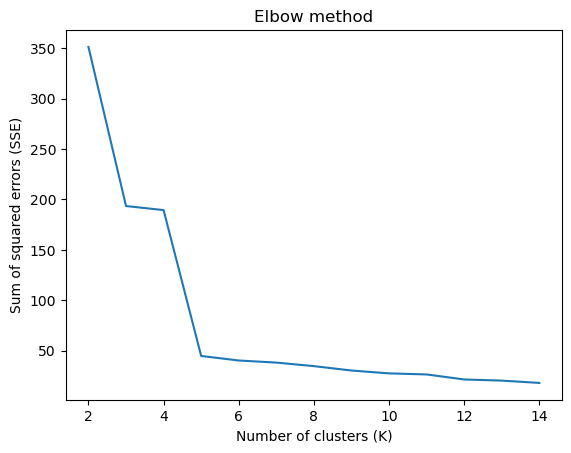

Best number of cluster: 14


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

class ScratchKMeans():
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False, random_state=None):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.random_state = random_state
        self.centroids = None

    def fit(self, X):
        best_sse = np.inf
        best_centroids = None

        for _ in range(self.n_init):
            # Initialize centroids by randomly selecting data points
            np.random.seed(self.random_state)
            centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

            for _ in range(self.max_iter):
                # Assign each data point to the nearest centroid
                labels = self._assign_clusters(X, centroids)

                # Update centroids based on the mean of data points in each cluster
                new_centroids = self._update_centroids(X, labels)

                # Check for convergence
                if np.linalg.norm(new_centroids - centroids) < self.tol:
                    break

                centroids = new_centroids

            # Calculate SSE for the current initialization
            _sse = self._calculate_sse(X, centroids)

            # Update best result if the current inertia is lower
            if _sse < best_sse:
                best_sse = _sse
                best_centroids = centroids

        self.centroids = best_centroids

        if self.verbose:
            print(f"Number of iterations: {self.max_iter}")
            print(f"Best SSE: {best_sse}")

    def _assign_clusters(self, X, centroids):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

    def _update_centroids(self, X, labels):
        new_centroids = np.array([X[labels == k].mean(axis=0) for
                                  k in range(self.n_clusters)])
        return new_centroids

    def _calculate_sse(self, X, centroids):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        #min_distances = np.min(distances, axis=1)
        sse = np.sum(distances**2)
        return sse

    def predict(self, X):
        labels = self._assign_clusters(X, self.centroids)
        return labels, self.centroids

### sse calculation ###

def calculate_sse(X, n_clusters, labels, centroids):
    """
    Calculates the sum of squared errors (SSE).

    Args:
        X (np.ndarray): The data matrix of shape (N, D).
        r (np.ndarray): The cluster assignment matrix of shape (N, K).
        mu (np.ndarray): The centroids of shape (K, D).

    Returns:
        float: The sum of squared errors.
    """
    sse = 0
    for k in range(n_clusters):
        Xk = X[labels == k, :]
        if len(Xk) > 0:
            sse += np.sum((Xk - centroids[k, :])**2)
    return sse

def elbow_method(X, max_clusters):

    """
    Performs the elbow method to determine the optimal number of clusters.

    Args:
        X (np.ndarray): The data matrix of shape (N, D).
        K_range (list): The range of K values to consider.

    Returns:
        int: The optimal number of clusters.
    """
    sse_values = []
    number_of_clusters = []
    for K in range(2, max_clusters):
        kmeans = ScratchKMeans(n_clusters=K,
                               n_init=10,
                               max_iter=100,
                               tol=1e-4,
                               verbose=True,
                               random_state=42)
        kmeans.fit(X)
        labels, centroids = kmeans.predict(X)
        sse = calculate_sse(X, K, labels, centroids)
        sse_values.append(sse)
        number_of_clusters.append(K)
    # Plot the elbow graph
    plt.plot(number_of_clusters, sse_values)
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Sum of squared errors (SSE)')
    plt.title('Elbow method')
    plt.show()

    # Find the elbow point
    elbow_point = 0
    min_sse = np.inf
    for i, sse in enumerate(sse_values):
        if sse < min_sse:
            min_sse = sse
            elbow_point = i

    return number_of_clusters[elbow_point]

# Load the data
X, _ = make_blobs(n_samples=100, n_features=2,
                  centers=4, cluster_std=0.5,
                  shuffle=True, random_state=0)

kmeans = ScratchKMeans(n_clusters=4,
                       n_init=10,
                       max_iter=100,
                       tol=1e-4, verbose=True,
                       random_state=42)
kmeans.fit(X)
predicted_labels = kmeans.predict(X)
K = elbow_method(X, max_clusters=15)

print("Best number of cluster:", K)